# ECON526: Quantitative Economics with Data Science Applications

Applications of Linear Algebra and Eigenvalues

Jesse Perla (University of British Columbia)

# Overview

## Motivation and Materials

-   In this lecture, we will cover some applications of the tools we
    developed in the previous lecture
-   The goal is to build some useful tools to sharpen your intuition on
    linear algebra and eigenvalues/eigenvectors, and practice some basic
    coding

## Packages

-   Some additional material and references

    -   [QuantEcon
        Python](https://python.quantecon.org/linear_algebra.html)
    -   [QuantEcon
        DataScience](https://datascience.quantecon.org/scientific/applied_linalg.html)
    -   [A First Course in Quantitative Economics with
        Python](https://intro.quantecon.org/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numpy.linalg import cond, matrix_rank, norm
from scipy.linalg import inv, solve, det, eig, lu, eigvals
from scipy.linalg import solve_triangular, eigvalsh, cholesky

# Difference Equations

## Linear Difference Equations as Iterative Maps

-   Consider $A : \mathbb{R}^N \to \mathbb{R}^N$ as the linear map for
    the state $x_t \in \mathbb{R}^N$
-   An example of a linear difference equation is $$
    x_{t+1} = A x_t
    $$ where

$$
A \equiv \begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.8 \\
\end{bmatrix}
$$

In [3]:
A = np.array([[0.9, 0.1], [0.5, 0.8]])
x_0 = np.array([1, 1])
x_1 = A @ x_0
print(f"x_1 = {x_1}, x_2 = {A @ x_1}")

x_1 = [1.  1.3], x_2 = [1.03 1.54]

## Iterating with $\rho(A) > 1$

Iterate $x_{t+1} = A x_t$ from $x_0$ for $t=100$

In [4]:
x_0 = np.array([1, 1])
t = 200
x_t = np.linalg.matrix_power(A, t) @ x_0
rho_A = np.max(np.abs(eigvals(A)))
print(f"rho(A) = {rho_A}")
print(f"x_{t} = {x_t}")

rho(A) = 1.079128784747792
x_200 = [3406689.32410674 6102361.18640517]

-   Diverges to
    $x_{\infty} = \begin{bmatrix} \infty & \infty \end{bmatrix}^T$
-   $\rho = 1 + 0.079$ says in the worst case (i.e., $x_t \propto$ the
    eigenvector associated with $\lambda = 1.079$ eigenvalue), expands
    by $7.9\%$ on each iteration

## Iterating with $\rho(A) < 1$

In [5]:
A = np.array([[0.6, 0.1], [0.5, 0.8]])
x_t = np.linalg.matrix_power(A, t) @ x_0
rho_A = np.max(np.abs(eigvals(A)))
print(f"rho(A) = {rho_A}")
print(f"x_{t} = {x_t}")

rho(A) = 0.9449489742783178
x_200 = [6.03450418e-06 2.08159603e-05]

-   Converges to $x_{\infty} = \begin{bmatrix} 0 & 0 \end{bmatrix}^T$

## Iterating with $\rho(A) = 1$

-   To make a matrix that has $\rho(A) = 1$ reverse eigendecomposition!
-   Leave previous eigenvectors in $Q$, change $\Lambda$ to force
    $\rho(A)$ directly

In [6]:
Q = np.array([[-0.85065081, -0.52573111], [0.52573111, -0.85065081]])
print(f"check orthogonal: dot(x_1,x_2) approx 0: {np.dot(Q[:,0], Q[:,1])}")
Lambda = [1.0, 0.8]  # choosing eigenvalue so max_n|lambda_n| = 1
A = Q @ np.diag(Lambda) @ inv(Q)
print(f"rho(A) = {np.max(np.abs(eigvals(A)))}")
print(f"x_{t} = {np.linalg.matrix_power(A, t) @ x_0}")

check orthogonal: dot(x_1,x_2) approx 0: 0.0
rho(A) = 1.0
x_200 = [ 0.27639321 -0.17082039]

# Unemployment Dynamics

## Dynamics of Employment without Population Growth

-   Consider an economy where in a given year $\alpha = 5\%$ of employed
    workers lose job and $\phi = 10\%$ of unemployed workers find a job
-   We start with $E_0 = 900,000$ employed workers, $U_0 = 100,000$
    unemployed workers, and no birth or death. Dynamics for the year:

$$
\begin{aligned}
E_{t+1} &= (1-\alpha) E_t + \phi U_t\\
U_{t+1} &= \alpha E_t + (1-\phi) U_t
\end{aligned}
$$

## Write as Linear System

-   Use matrices and vectors to write as a linear system

$$
\underbrace{\begin{bmatrix} E_{t+1}\\U_{t+1}\end{bmatrix}}_{X_{t+1}} = \underbrace{\begin{bmatrix} 1-\alpha & \phi \\ \alpha & 1-\phi \end{bmatrix}}_{ A} \underbrace{\begin{bmatrix} E_{t}\\U_{t}\end{bmatrix}}_{X_t}
$$

## Simulating

Simulate by iterating $X_{t+1} = A X_t$ from $X_0$ until $T=100$

In [7]:
def simulate(A, X_0, T):
    X = np.zeros((2, T+1))
    X[:,0] = X_0
    for t in range(T):
        X[:,t+1] = A @ X[:,t]
    return X
X_0 = np.array([900000, 100000])
A = np.array([[0.95, 0.1], [0.05, 0.9]])
T = 100
X = simulate(A, X_0, T)
print(f"X_{T} = {X[:,T]}")

X_100 = [666666.6870779  333333.31292209]

## Dynamics of Unemployment

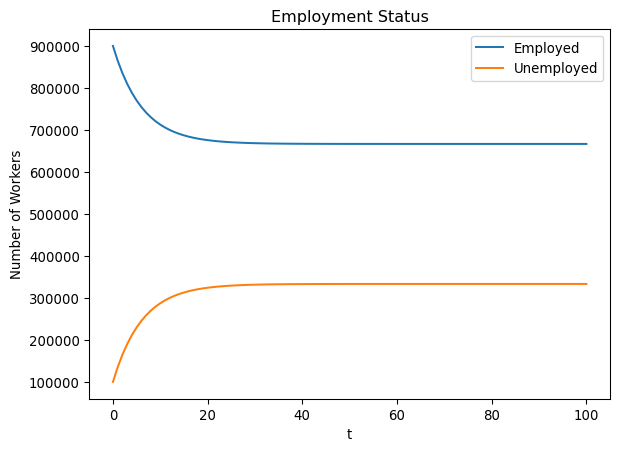

In [8]:
fig, ax = plt.subplots()
ax.plot(range(T+1), X.T,
  label=["Employed", "Unemployed"])
ax.set(xlabel="t",
  ylabel="Number of Workers",
  title="Employment Status")
ax.legend()
plt.show()

## Convergence to a Longrun Distribution

-   Find $X_{\infty}$ by iterating $X_{t+1} = A X_t$ many times from a
    $X_0$?

    -   Check if it has converged with $X_{\infty} \approx A X_{\infty}$
    -   Is $X_{\infty}$ the same from any $X_0$? Will discuss
        “ergodicity” later

-   Alternatively, note that this expression is the same as

    $$
    1 \times \bar{X} = A \bar{X}
    $$

    -   i.e, a $\lambda = 1$ where $\bar{X}$ is the corresponding
        eigenvector of $A$
    -   Is $\lambda = 1$ always an eigenvalue? (yes if all
        $\sum_{n=1}^N A_{ni} = 1$ for all $i$)
    -   Does $\bar{X} = X_{\infty}$? For any $X_0$?
    -   Multiple eigenvalues with $\lambda = 1 \implies$ multiple
        $\bar{X}$

## Using the First Eigenvector for the Steady State

In [9]:
Lambda, Q = eig(A)
print(f"real eigenvalues = {np.real(Lambda)}")
print(f"eigenvectors in columns of =\n{Q}")
print(f"first eigenvalue = 1? \
{np.isclose(Lambda[0], 1.0)}")
X_bar = Q[:,0] / np.sum(Q[:,0]) * np.sum(X_0)
print(f"X_bar = {X_bar}\nX_{T} = {X[:,T]}")

real eigenvalues = [1.   0.85]
eigenvectors in columns of =
[[ 0.89442719 -0.70710678]
 [ 0.4472136   0.70710678]]
first eigenvalue = 1? True
X_bar = [666666.66666667 333333.33333333]
X_100 = [666666.6870779  333333.31292209]

## Using the Second Eigenvalue for the Convergence Speed

-   The second largest ($\lambda_2 < 1$) provides information on the
    speed of convergence
    -   $0$ is instantaneous convergence here
    -   $1$ is no convergence here
-   We will create a new matrix with the same steady state, different
    speed
    -   To do this, build a new matrix with the same eigenvectors (in
        particular the same eigenvector associated with the $\lambda=1$
        eigenvalue)
    -   But we will replace the eigenvalues
        $\begin{bmatrix}1.0 & 0.85\end{bmatrix}$ with
        $\begin{bmatrix}1.0 & 0.5\end{bmatrix}$
    -   Then we will reconstruct $A$ matrix and simulate again
-   Intuitively we will see the that the resulting $A_{\text{fast}}$
    implies $\alpha$ and $\phi$ which are larger by the same proportion

## Simulating with Different Eigenvalues

In [10]:
Lambda_fast = np.array([1.0, 0.4])
A_fast = Q @ np.diag(Lambda_fast) @ inv(Q) # same eigenvectors
print("A_fast =\n", A_fast)
print(f"alpha_fast/alpha = {A_fast[1,0]/A[1,0]:.2g}, \
phi_fast/phi = {A_fast[0,1]/A[0,1]:.2g}")
X_fast = simulate(A_fast, X_0, T)
print(f"X_{T} = {X_fast[:,T]}")

A_fast =
 [[0.8 0.4]
 [0.2 0.6]]
alpha_fast/alpha = 4, phi_fast/phi = 4
X_100 = [666666.66666667 333333.33333333]

## Convergence Dynamics of Unemployment

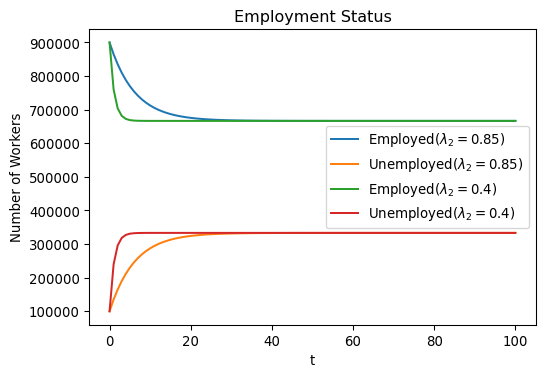

In [11]:
lambda_2_old = np.real(Lambda[1])
lambda_2_new = Lambda_fast[1]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(range(T+1), X.T, label=[rf"Employed$(\lambda_2={lambda_2_old})$", rf"Unemployed$(\lambda_2={lambda_2_old})$"])
ax.plot(range(T+1), X_fast.T, label=[rf"Employed$(\lambda_2={lambda_2_new})$", rf"Unemployed$(\lambda_2={lambda_2_new})$"])
ax.set(xlabel="t", ylabel="Number of Workers", title="Employment Status")
ax.legend()
plt.show()

# Present Discounted Values

## Geometric Series

-   Assume dividends follow $y_{t+1} = G y_t$ for $t=0,1,\ldots$ and
    $y_0$ is given

-   $G > 0$, dividends are discounted at factor $\beta > 1$ then
    $p_t = \sum_{s=0}^{\infty} \beta^s y_{t+s} = \frac{y_t}{1-\beta G}$

-   More generally if $x_{t+1} = A x_t$, $x_t \in \mathbb{R}^N$,
    $y_t = G x_t$ and $A \in \mathbb{R}^{N \times N}$, then

    $$
    \begin{aligned}
    p_t &= y_t + \beta y_{t+1} + \beta^2 y_{t+2} + \ldots = G x_t + \beta G A x_t + \beta^2 G A A  x_t + \ldots\\
    &= \sum_{s=0}^{\infty} \beta^s G A^s y_t\\
    &= G (I - \beta A)^{-1} x_t\quad,\text{ if } \rho(A) < 1/\beta
    \end{aligned}
    $$

-   where $\rho(A)$ is the spectral radius

## Discounting and the Spectral Radius

-   Intuitively, the spectral radius of $A$, the maximum scaling, must
    be less than discounting
-   Intuition from univariate:
    -   If $G \in \mathbb{R}^{1 \times 1}$ then $\text{eig}(G) = G$, so
        must have $|\beta G| < 1$

## PDV Example

Here is an example with $1 < \rho(A) < 1/\beta$. Try with different $A$

In [12]:
beta = 0.9
A = np.array([[0.85, 0.1], [0.2, 0.9]])
G = np.array([[1.0, 1.0]]) # row vector
x_0 = np.array([1.0, 1.0])
p_t = G @ solve(np.eye(2) - beta * A, x_0)
#p_t = G @ inv(np.eye(2) - beta * A) @ x_0 # alternative
rho_A = np.max(np.abs(np.real(eigvals(A))))
print(f"p_t = {p_t[0]:.4g}, spectral radius = {rho_A:.4g}, 1/beta = {1/beta:.4g}")

p_t = 24.43, spectral radius = 1.019, 1/beta = 1.111

# (Optional) Matrix Conditioning and Stability

## Matrix Conditioning

-   Poorly conditioned matrices can lead to inaccurate or wrong
    solutions
-   Tends to happen when matrices are close to singular or when they
    have very different scales - so there will be times when you need to
    rescale your problems

In [13]:
eps = 1e-7
A = np.array([[1, 1], [1 + eps, 1]])
print(f"A =\n{A}")
print(f"A^{-1} =\n{inv(A)}")

A =
[[1.        1.       ]
 [1.0000001 1.       ]]
A^-1 =
[[-9999999.99336215  9999999.99336215]
 [10000000.99336215 -9999999.99336215]]

## Condition Numbers of Matrices

-   $\det(A) \approx 0$ may say it is “almost” singular, but it is not
    scale-invariant
-   $\text{cond}(A) \equiv ||A|| \cdot ||A^{-1}||$ where $||\cdot||$ is
    the matrix norm - expensive to calculate in practice. Connected to
    eigenvalues $\text{cond}(A) = |\frac{\lambda_{max}}{\lambda_{min}}|$
-   Scale free measure of numerical issues for a variety of matrix
    operations
-   Intuition: if $\text{cond}(A) = K$, then $b \to b + \nabla b$ change
    in $b$ amplifies to a $x \to x + K \nabla b$ error when solving
    $A x = b$.
-   See [Matlab Docs on
    inv](https://www.mathworks.com/help/matlab/ref/inv.html#bu6sfy8-1)
    for example, where `inv` is a bad idea due to poor conditioning

In [14]:
print(f"condition(I) = {cond(np.eye(2))}")
print(f"condition(A) = {cond(A)}, condition(A^(-1)) = {cond(inv(A))}")

condition(I) = 1.0
condition(A) = 40000001.962777555, condition(A^(-1)) = 40000002.02779216

## Example with Interpolation

-   Consider fitting data $x\in\mathbb{R}^{N+1}$ and
    $y\in\mathbb{R}^{N+1}$ with an $N$-degree polynomial
-   That is, find $c \in \mathbb{R}^{N+1}$ such that

$$
\begin{aligned}
c_0 + c_1 x_1 + c_2 x_1^2 + \ldots + c_N x_1^N &= y_1\\
\dots &= \dots\\
c_0 + c_1 x_N + c_2 x_N^2 + \ldots + c_N x_N^N &= y_N\\
\end{aligned}
$$

-   Which we can then use as $P(x) = \sum_{n=0}^N c_n x^n$ to
    interpolate between the points

## Writing as a Linear System

-   Define a matrix of all of the powers of the $x$ values

$$
A \equiv \begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^N\\
\vdots & \vdots &\vdots & \vdots & \vdots\\
1 & x_N & x_N^2 & \ldots & x_N^N
\end{bmatrix}
$$

-   Then solve for $c$ as the solution (where $A$ is invertible if $x_n$
    are unique)

$$
A c = y
$$

## Solving an Example

-   Let’s look at the numerical error here from the interpolation using
    the inf-norm, i.e., $||x||_{\infty} = \max_n |x_n|$

In [15]:
N = 5
x = np.linspace(0.0, 10.0, N + 1)
y = np.exp(x)  # example function to interpolate
A = np.array([[x_i**n for n in range(N + 1)] for x_i in x])  # or np.vander
c = solve(A, y)
c_inv = inv(A) @ y
print(f"error = {norm(A @ c - y, np.inf)}, \
error using inv(A) = {norm(A @ c_inv - y, np.inf)}")
print(f"cond(A) = {cond(A)}")

error = 1.7564616427989677e-11, error using inv(A) = 6.402842700481415e-10
cond(A) = 564652.3214007876

## Things Getting Poorly Conditioned Quickly

In [16]:
N = 10
x = np.linspace(0.0, 10.0, N + 1)
y = np.exp(x)  # example function to interpolate
A = np.array([[x_i**n for n in range(N + 1)] for x_i in x])  # or np.vander
c = solve(A, y)
c_inv = inv(A) @ y # Solving with inv(A) instead of solve(A, y)
print(f"error = {norm(A @ c - y, np.inf)}, \
error using inv(A) = {norm(A @ c_inv - y, np.inf)}")
print(f"cond(A) = {cond(A)}")

error = 4.656612873077393e-10, error using inv(A) = 3.0141090974211693e-05
cond(A) = 4462825405562.683

## Matrix Inverses Fail Completely for $N = 20$

In [17]:
N = 20
x = np.linspace(0.0, 10.0, N + 1)
y = np.exp(x)  # example function to interpolate
A = np.array([[x_i**n for n in range(N + 1)] for x_i in x])  # or np.vander
c = solve(A, y)
c_inv = inv(A) @ y # Solving with inv(A) instead of solve(A, y)
print(f"error = {norm(A @ c - y, np.inf)}, \
error using inv(A) = {norm(A @ c_inv - y, np.inf)}")
print(f"cond(A) = {cond(A):.4g}")

error = 8.403731044381857e-10, error using inv(A) = 9399.111522559022
cond(A) = 8.421e+24

C:\Users\Phil\AppData\Local\Temp\ipykernel_20424\1043797195.py:5: LinAlgWarning: Ill-conditioned matrix (rcond=8.69804e-28): result may not be accurate.
  c = solve(A, y)

## Moral of this Story

-   Use `solve`, which is faster and can often solve ill-conditioned
    problems. Rarely use `inv`, and only when you know the problem is
    well-conditioned
-   Check conditioning of matrices when doing numerical work as an
    occasional diagnostic, as it is a good indicator of potential
    problems and collinearity
-   For approximation, never use a monomial basis for polynomials
    -   Prefer polynomials like Chebyshev, which are designed to be as
        orthogonal as possible

In [18]:
N = 40
x = np.linspace(-1, 1, N+1)  # Or any other range of x values
A = np.array([[np.polynomial.Chebyshev.basis(n)(x_i) for n in range(N+1)] for x_i in x])
A_monomial = np.array([[x_i**n for n in range(N + 1)] for x_i in x])  # or np.vander
print(f"cond(A) = {cond(A):.4g}, cond(A_monomial) = {cond(A_monomial):.4g}")

cond(A) = 3.64e+09, cond(A_monomial) = 2.871e+17